# MLOps Workshop - Git & Deployment

In questo notebook esploreremo le best practices del deployment di modelli di Machine Learning su Cloud Pak for Data. 

Il workshop è suddiviso in due parti: la prima parte simulerà lo sviluppo di un modello di ML seguendo le guidelines Git Flow, mentre la seconda eseguirà il deployment del modello in un deployment space. 

Svilupperemo un semplice modello Tensorflow per la classificazione di cifre scritte a mano prese dal dataset MNIST.

# General + Git setup

Andiamo ad installare ed importare le librerie necessarie e ad impostare le variabili di ambiente per gestire il git flow.

In [1]:
# Installazione wget e tensorflow_datasets 

!pip install -q wget
!pip install -q tensorflow_datasets

In [2]:
# Import librerie

import json
import os
import requests
import subprocess
import wget
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

from IPython.core.display import display, HTML

Matplotlib created a temporary config/cache directory at /tmp/1000650000/matplotlib-4rj29qt1 because the default path (/home/wsuser/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Impostiamo come variabili globali il nome del branch (CURRENT_BRANCH) preso direttamente dalle variabili di ambiente e il nome dell'environment (CURRENT_ENV), il quale può essere soltanto prd o dev.

In [3]:
CURRENT_BRANCH = subprocess.run(['git', 'rev-parse', '--abbrev-ref', 'HEAD'], stdout=subprocess.PIPE)\
    .stdout.strip().decode("utf-8")

if CURRENT_BRANCH in ['prd']:
    CURRENT_ENV=CURRENT_BRANCH
else:
    CURRENT_ENV='dev'
    
print('Current branch     : {}'.format(CURRENT_BRANCH))
print('Current environment: {}'.format(CURRENT_ENV))

Current branch     : dev
Current environment: dev


## Data setup

Scarichiamo un'immagine di esempio per iniziare ad esplorare i dati 

In [4]:
# Download del file di esempio e caricamento in una variabile

sample_canvas_data_filename = 'mnist-html-canvas-image-data.json'
url = 'https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/data/mnist/' + sample_canvas_data_filename
if not os.path.isfile(sample_canvas_data_filename): wget.download(url)

with open(sample_canvas_data_filename) as data_file:
    sample_cavas_data = json.load(data_file)

Height (n): 187 pixels

Num image data entries: 139876 - (n * n * 4) elements - RGBA values



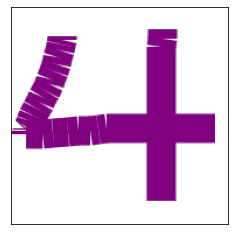

In [5]:
# Plot dell'immagine con matplotlib

print("Height (n): " + str(sample_cavas_data["height"]) + " pixels\n")
print("Num image data entries: " + str(len( sample_cavas_data["data"])) + " - (n * n * 4) elements - RGBA values\n")

rgba_arr = np.asarray(sample_cavas_data["data"]).astype('uint8')
n = sample_cavas_data["height"]
plt.figure()
plt.imshow( rgba_arr.reshape(n, n, 4))
plt.xticks([])
plt.yticks([])
plt.show()

Download del dataset completo da Tensorflow datasets

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    data_dir="../data_asset"
)

Normalizzazione e divisione del dataset in training e test.

In [7]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [8]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

# Definizione e training del modello

Definiamo una rete composta da 2 layer Dense (fully connected) alla quale aggiungeremo un layer Lambda che faccia restituire la classificazione effettiva dell'immagine (e non le probabilità).

In [9]:
model = tf.keras.models.Sequential([
    layers.Conv2D(1, (3, 3), activation='relu', input_shape=(28, 28, 1)), # <- NON MODIFICARE
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'), # <- HINT
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(32, (3, 3), activation='relu'), # <- HINT
    layers.Flatten(),
    layers.Dense(64, activation='softmax'),
    layers.Dense(10) # <- NON MODIFICARE
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=2,
    validation_data=ds_test,
)

model.add(tf.keras.layers.Lambda(lambda x: tf.keras.backend.cast(tf.keras.backend.argmax(x), dtype='int32'), name='classes'))

Epoch 1/2
469/469 [==============================] - 137s 241ms/step - loss: 1.7965 - sparse_categorical_accuracy: 0.6399 - val_loss: 1.4525 - val_sparse_categorical_accuracy: 0.6957
Epoch 2/2
469/469 [==============================] - 108s 229ms/step - loss: 1.2376 - sparse_categorical_accuracy: 0.6968 - val_loss: 1.0541 - val_sparse_categorical_accuracy: 0.7010


Testiamo il modello sul dataset di test (usato anche come validation) per vedere il formato dell'output.

In [10]:
model.predict(ds_test)

array([2, 0, 4, ..., 3, 0, 3], dtype=int32)

Salviamo il modello sul filesystem locale.

In [11]:
model_path='../data_asset/mnist-dl-model'
tf.saved_model.save(model, model_path)

2022-04-27 09:47:48.520206: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../data_asset/mnist-dl-model/assets


INFO:tensorflow:Assets written to: ../data_asset/mnist-dl-model/assets


# Deployment

In questa parte andremo a fare il deploy del modello sviluppato, andandolo prima a salvare tra gli asset di un deployment space e poi facendo il deploy dello stesso.

![DIAGRAM](img/diagram.png)

## Credentials 

Andiamo a salvare in una variabile le credenziali per accedere al modello, tra cui l'access token. Queste variabili sono salvate dal CP4D direttamente nelle variabili di ambiente, per cui possiamo recuperarle in maniera rapida.

In [12]:
cpdtoken=os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
    "token": cpdtoken,
    "instance_id" : "openshift",
    "url": os.environ['RUNTIME_ENV_APSX_URL'],
    "version": "4.0"
}

Impostiamo il client di Watson Machine Learning con le credenziali rintracciate.

In [13]:
from ibm_watson_machine_learning import APIClient
client = APIClient(wml_credentials)

## Deployment Space

Troviamo i deployment space e impostiamo l'id nella variabile `space_id`. Se il deployment space non esiste ne viene creato uno in automatico.

In [14]:
# List deployment spaces

client.spaces.list(limit=10)

------------------------------------  ---------  ------------------------
ID                                    NAME       CREATED
9a01b22f-3d49-49cb-9b25-53a8b64b4f82  mlops-dev  2022-04-27T09:36:52.392Z
------------------------------------  ---------  ------------------------


In [20]:
# TODO Change ID
space_id = ''

use_existing_space=True
space_name = f'mlops-{CURRENT_ENV}'

# Codice per creare il deployment space da codice

for space in client.spaces.get_details()['resources']:

    if space['entity']['name'] == space_name:
        print("Deployment space with name",space_name,"already exists . .")
        space_id=space['metadata']['id']
        client.set.default_space(space_id)
        if use_existing_space==False:

            for deployment in client.deployments.get_details()['resources']:
                print("Deleting deployment",deployment['entity']['name'], "in the space",)
                deployment_id=deployment['metadata']['id']
                client.deployments.delete(deployment_id)
            print("Deleting Space ",space_name,)
            client.spaces.delete(space_id)
            time.sleep(5)
        else:
            print("Using the existing space")

if (space_id == "" or use_existing_space == False):
    print("\nCreating a new deployment space - ",space_name)
    space_meta_data = {
        client.spaces.ConfigurationMetaNames.NAME : space_name
    }

    stored_space_details = client.spaces.store(space_meta_data)

    space_id = stored_space_details['metadata']['id']

client.set.default_space(space_id)


Deployment space with name mlops-dev already exists . .
Using the existing space


'SUCCESS'

## Store Model

Salviamo il modello nel repository, ovvero lo spazio 'Assets' del Deployment Space. Creiamo anche una revision per poter versionare il modello.

Se il model ID non viene passato o non viene trovato all'interno del deployment space, andiamo a crearne uno nuovo e ad assegnare una nuova revision all'asset.

In [23]:
# TODO Change ID

model_id = ""
model_exist = False

if model_id != "":
    for entity in client.repository.get_details()['models']['resources']:
        model_exist = entity['metadata']['id'] == model_id or model_exist

    assert model_exist, "ID modello non esiste"

In [24]:
if not model_exist:
    sofware_spec_uid = client.software_specifications.get_id_by_name("tensorflow_rt22.1-py3.9")
    metadata = {
                client.repository.ModelMetaNames.NAME: "MNIST Tensorflow Model",
                client.repository.ModelMetaNames.TYPE: 'tensorflow_2.7',
                client.repository.ModelMetaNames.TAGS: ['OCR'],
                client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
    }

    model_details = client.repository.store_model(
        model=model_path,
        meta_props=metadata
    )
    model_id = client.repository.get_model_id(model_details)
else:
    metadata = {
            client.repository.ModelMetaNames.NAME: 'MNIST Tensorflow Model',
    }

    model_details = client.repository.update_model(
        model_id,
        updated_meta_props=metadata, update_model=model_path
    )
    model_id = client.repository.get_model_id(model_details)

print(model_id)    
stored_model_revision_details = client.repository.create_model_revision( model_uid=model_id)
print(stored_model_revision_details)

08ed3ee4-e69d-4705-81fd-0cfe2c8f8944
{'entity': {'hybrid_pipeline_software_specs': [], 'software_spec': {'id': 'acd9c798-6974-5d2f-a657-ce06e986df4d', 'name': 'tensorflow_rt22.1-py3.9'}, 'type': 'tensorflow_2.7'}, 'metadata': {'commit_info': {'committed_at': '2022-04-27T09:55:30.002Z'}, 'created_at': '2022-04-27T09:53:41.060Z', 'id': '08ed3ee4-e69d-4705-81fd-0cfe2c8f8944', 'modified_at': '2022-04-27T09:55:30.345Z', 'name': 'MNIST Tensorflow Model', 'owner': '1000331002', 'resource_key': '3e73f11d-c8ea-4d5d-a74a-2bb53fc0d1bd', 'rev': '2', 'space_id': '9a01b22f-3d49-49cb-9b25-53a8b64b4f82', 'tags': ['OCR']}, 'system': {'warnings': []}}


## Deploy Model

Andiamo a fare il deployment del modello creato.

Se il deployment ID non viene passato o non viene trovato all'interno del deployment space, andiamo a crearne uno nuovo.

Qualora si passasse un deployment ID già esistente, fa l'update del deployment aggiungendo l'asset con l'ultima revision creata.

In [25]:
# TODO Change ID

deployment_id = ""
deployment_exist = False

if deployment_id != "":
    for entity in client.deployments.get_details()['resources']:
        deployment_exist = entity['metadata']['id'] == deployment_id or deployment_exist

    assert deployment_exist, "ID Deployment non esiste"

In [26]:
# Deploy del modello
rev = int(stored_model_revision_details['metadata']['rev'])
if not deployment_exist:
    metadata = {
        client.deployments.ConfigurationMetaNames.NAME: "MNIST Tensorflow Deployed Model",
        client.deployments.ConfigurationMetaNames.TAGS: ['OCR'],
        client.deployments.ConfigurationMetaNames.ONLINE: {},
        client.deployments.ConfigurationMetaNames.ASSET: {"id": model_id,"rev":str(rev)}
    }

    model_deployment_details = client.deployments.create(model_id, meta_props=metadata)
    deployment_id = client.deployments.get_uid(model_deployment_details)
    print(deployment_id)
else:
    metadata = {
        client.deployments.ConfigurationMetaNames.ASSET: {"id": model_id,"rev":str(rev)}
    }
    model_deployment_details = client.deployments.update(deployment_id, changes=metadata)


Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
Since ASSET is patched, deployment with new asset id/rev is being started. Monitor the status using deployments.get_details(deployment_uid) api


In [27]:
%%capture
while client.deployments.get_details(deployment_id)['entity']['status']['state']!='ready':
    pass

In [28]:
print("Deployment Ready")

Deployment Ready


# Test

Testiamo il modello via API e via richieste HTTPS.

In [29]:
# Preprocessing dati

def getRGBAArr(canvas_data):
    dimension = canvas_data["height"]
    rgba_data = canvas_data["data"]
    rgba_arr  = np.asarray(rgba_data).astype('uint8')
    return rgba_arr.reshape(dimension, dimension, 4)

def getNormAlphaList(img):
    alpha_arr       = np.array(img.split()[-1])
    norm_alpha_arr  = alpha_arr / 255
    return norm_alpha_arr

canvas_data   = sample_cavas_data     
rgba_arr      = getRGBAArr(canvas_data)
img           = Image.fromarray(rgba_arr, 'RGBA') 
sm_img        = img.resize((28, 28), Image.LANCZOS)
alpha_list    = getNormAlphaList(sm_img)
alpha_list    = alpha_list.reshape((1,28,28,1))
model_payload = {"input_data": [{"values" : alpha_list}]} 

In [30]:
# Predict via API

predictions = client.deployments.score(deployment_id, model_payload)
print(json.dumps(predictions))

{"predictions": [{"id": "classes", "values": [4]}]}


In [31]:
# Predict via HTTP request

header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + cpdtoken}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_scoring = model_payload

response_scoring = requests.post(f'https://cpd-cpd-instance.itzroks-666000zj44-mn5nm2-4b4a324f027aea19c5cbc0c3275c4656-0000.eu-de.containers.appdomain.cloud/ml/v4/deployments/{deployment_id}/predictions?version=2022-04-21', json=payload_scoring, headers=header, verify=False)
print("Scoring response")
print(json.loads(response_scoring.text))

Scoring response
{'predictions': [{'id': 'classes', 'values': [4]}]}
